In [20]:
import os
import sys
import re
from nltk.corpus import stopwords
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [21]:
from pyspark.sql import SparkSession, SQLContext
import os
import pyspark.sql.functions as f
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

In [22]:
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

In [23]:
data = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_raw.csv"))

In [24]:
import nltk
nltk.pos_tag(["Arthur", "loves", "fish"])

[('Arthur', 'NNP'), ('loves', 'VBZ'), ('fish', 'JJ')]

In [25]:
import pyspark.sql.functions as f
data = data.withColumn('line', f.explode(f.split(f.col('text'), '\n')))
data.show()

+--------------------+--------------------+--------------------+--------------------+
|                  id|                type|                text|                line|
+--------------------+--------------------+--------------------+--------------------+
|                1905|                   C|                   "|                   "|
|             reading|             writing|             working|             working|
|knowledge  to ren...|          and gentle|                kind|                kind|
|    This gentlewoman| whose name was T...| was the widow of...| was the widow of...|
|        Mrs. Teachum| though exceeding...|         yet thought|         yet thought|
|             desires| and did not seek...| she was resolved to| she was resolved to|
|would be prevaile...| great applicatio...|            when any|            when any|
|        reprehending| and that pretty ...| any girl that wa...| any girl that wa...|
|dignity and autho...| by her steady be...| that the g

In [26]:
def removeProperNouns(sentence):
    tagged_sentence = nltk.tag.pos_tag(nltk.word_tokenize(sentence))
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    return ' '.join(edited_sentence)

In [27]:
classics = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_raw.csv"))
StopWords = nltk.corpus.stopwords.words("english")
classics = data.rdd.map(lambda x : x['line']).filter(lambda x: x is not None)
tokens = classics                                                 \
    .map(lambda document: removeProperNouns(document))             \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])     \
    .zipWithIndex()

In [28]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [29]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [30]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

In [31]:
data.printSchema()
data.show()

root
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- text: string (nullable = true)
 |-- line: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+
|                  id|                type|                text|                line|
+--------------------+--------------------+--------------------+--------------------+
|                1905|                   C|                   "|                   "|
|             reading|             writing|             working|             working|
|knowledge  to ren...|          and gentle|                kind|                kind|
|    This gentlewoman| whose name was T...| was the widow of...| was the widow of...|
|        Mrs. Teachum| though exceeding...|         yet thought|         yet thought|
|             desires| and did not seek...| she was resolved to| she was resolved to|
|would be prevaile...| great applicatio...|            when any|            wh

In [32]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [33]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[9, 13, 19, 27, 6...|[0.03284104834525...|[shall, come, mad...|
|    1|[6, 18, 17, 22, 5...|[0.03952314953165...|[never, away, mig...|
|    2|[14, 35, 41, 38, ...|[0.02752797824544...|[looking, well, c...|
|    3|[4, 11, 15, 16, 3...|[0.03790110878192...|[little, good, an...|
|    4|[0, 23, 61, 99, 1...|[0.16353925909448...|[said, even, foun...|
|    5|[8, 21, 20, 28, 6...|[0.03483142102788...|[think, quite, ra...|
|    6|[1, 3, 12, 34, 51...|[0.05819504368595...|[would, like, muc...|
|    7|[7, 31, 25, 42, 4...|[0.03587448282174...|[must, cried, dea...|
|    8|[2, 10, 37, 49, 5...|[0.06232441457444...|[could, though, f...|
|    9|[5, 26, 24, 32, 4...|[0.03872401433071...|[know, went, make...|
+-----+--------------------+--------------------+--------------------+



In [34]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[9, 13, 19, 27, 6...|[0.03284104834525...|shall come made t...|
|    1|[6, 18, 17, 22, 5...|[0.03952314953165...|never away might ...|
|    2|[14, 35, 41, 38, ...|[0.02752797824544...|looking well came...|
|    3|[4, 11, 15, 16, 3...|[0.03790110878192...|little good answe...|
|    4|[0, 23, 61, 99, 1...|[0.16353925909448...|said even found r...|
|    5|[8, 21, 20, 28, 6...|[0.03483142102788...|think quite rathe...|
|    6|[1, 3, 12, 34, 51...|[0.05819504368595...|would like much t...|
|    7|[7, 31, 25, 42, 4...|[0.03587448282174...|must cried dear t...|
|    8|[2, 10, 37, 49, 5...|[0.06232441457444...|could though felt...|
|    9|[5, 26, 24, 32, 4...|[0.03872401433071...|know went make gr...|
+-----+--------------------+--------------------+--------------------+



In [35]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=True)
counts.show()

+--------+-----+
|    word|count|
+--------+-----+
|    hope|    1|
|   still|    1|
|    even|    1|
|  father|    1|
|  always|    1|
|   could|    1|
|    sure|    1|
|    hand|    1|
|    must|    1|
|answered|    1|
|    back|    1|
|  seemed|    1|
|    face|    1|
|  rather|    1|
|  turned|    1|
|    love|    1|
|  looked|    1|
|  please|    1|
| turning|    1|
|    kind|    1|
+--------+-----+
only showing top 20 rows



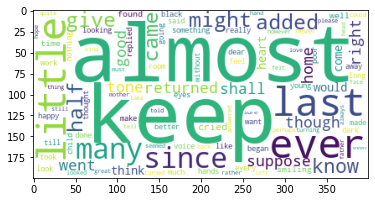

In [36]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()


In [37]:
nltk.pos_tag(["lisa"])

[('lisa', 'NN')]

In [38]:
removeProperNouns("Lisa is me")

'is me'